# TAG and Text Models for Kenya Only
This notebook has models for the TAGS column only and for all text columns combined for the country of Kenya only. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [49]:
full_kiva = pd.read_csv('/Users/precious/dsi/Group-Project/kivamix.csv')

In [4]:
full_kiva.head(2)

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,...,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,year
0,1455352,Raisa Jokasta,Spanish,"En la ciudad de Portoviejo, conocida como la c...",The city of Portoviejo is located in the valle...,1075.0,1075.0,1,2638561.0,NaN,...,12,1,1,"#Repeat Borrower, #Health and Sanitation",Raisa Jokasta,female,true,monthly,field_partner,2018
1,1727469,Lorna,English,"Lorna is a married woman, 39 years old with fi...","Lorna is a married woman, 39 years old with fi...",225.0,400.0,0,3108106.0,NaN,...,8,1,1,"#Woman-Owned Business, #Parent",Lorna,female,true,monthly,field_partner,2019


In [22]:
full_kiva['STATUS'].value_counts(normalize=True)

1    0.835011
0    0.164989
Name: STATUS, dtype: float64

In [8]:
full_kiva['COUNTRY_NAME'].value_counts()

Philippines                         88691
Kenya                               51170
El Salvador                         21840
Cambodia                            19196
Colombia                            18590
                                    ...  
Iraq                                    4
Saint Vincent and the Grenadines        3
Bangladesh                              1
Afghanistan                             1
Benin                                   1
Name: COUNTRY_NAME, Length: 84, dtype: int64

In [71]:
# creating dataframe with only columns I want to keep for nlp
kiva = full_kiva[['LOAN_ID', 'COUNTRY_NAME', 'STATUS', 'DESCRIPTION_TRANSLATED', 'LOAN_USE', 'TAGS']]

In [51]:
kiva.head(2)

,LOAN_ID,COUNTRY_NAME,STATUS,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS
0,1455352,Ecuador,1,The city of Portoviejo is located in the valle...,to purchase natural products.,"#Repeat Borrower, #Health and Sanitation"
1,1727469,Philippines,0,"Lorna is a married woman, 39 years old with fi...","to purchase additional stocks of Avon, Natasha...","#Woman-Owned Business, #Parent"


In [72]:
# creating dataframe of data only from Kenya
kiva = kiva[kiva['COUNTRY_NAME']=='Kenya']

In [73]:
kiva.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51170 entries, 7 to 419149
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LOAN_ID                 51170 non-null  int64 
 1   COUNTRY_NAME            51170 non-null  object
 2   STATUS                  51170 non-null  int64 
 3   DESCRIPTION_TRANSLATED  50025 non-null  object
 4   LOAN_USE                50025 non-null  object
 5   TAGS                    43157 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.7+ MB


In [74]:
kiva['STATUS'].value_counts(normalize=True)

1    0.784659
0    0.215341
Name: STATUS, dtype: float64

In [75]:
# creating dataframe only for Tags to perform modeling
kiva_tags = kiva[['LOAN_ID', 'STATUS', 'TAGS']]

In [78]:
kiva_tags['STATUS'].value_counts(normalize=True)

1    0.746762
0    0.253238
Name: STATUS, dtype: float64

In [77]:
kiva_tags.dropna(inplace=True)

<ipython-input-77-4c77679f4007>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kiva_tags.dropna(inplace=True)


In [79]:
kiva_tags.head()

,LOAN_ID,STATUS,TAGS
7,1799331,1,#Parent
16,1294719,1,"#Animals, #Woman-Owned Business, volunteer_pic..."
21,1595847,0,"user_favorite, #Parent, #Woman-Owned Business"
41,1139606,1,"#Repeat Borrower, #Woman-Owned Business"
72,1018040,1,user_favorite


### Preprocessing Tags to keep them joined instead of vectorizing each word

In [86]:
kiva_tags.head(2)

,LOAN_ID,STATUS,TAGS,processed_TAGS
7,1799331,1,#Parent,#Parent
16,1294719,1,"#Animals, #Woman-Owned Business, volunteer_pic...","#Animals,#Woman-OwnedBusiness,volunteer_pick,#..."


In [82]:
# casting TAGS column to string to avoid erros in processing
kiva_tags['TAGS'] = kiva_tags['TAGS'].astype(str)

<ipython-input-82-831cc37a277f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kiva_tags['TAGS'] = kiva_tags['TAGS'].astype(str)


In [45]:
# casting TAGS column to string to avoid erros in processing
kiva_tags['TAGS'].dtypes

dtype('O')

In [83]:
# removing spaces within tags and creating new column w/changes to TAGS
kiva_tags['processed_TAGS'] = [row.replace(' ', '') for row in kiva_tags['TAGS']]

<ipython-input-83-865f64f52653>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kiva_tags['processed_TAGS'] = [row.replace(' ', '') for row in kiva_tags['TAGS']]


In [89]:
# removing dashes within tags 
kiva_tags['processed_TAGS'] = [row.replace('-', '') for row in kiva_tags['processed_TAGS']]

<ipython-input-89-c7221758a1e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kiva_tags['processed_TAGS'] = [row.replace('-', '') for row in kiva_tags['processed_TAGS']]


In [93]:
# tokenizing all rows
tokenizer = RegexpTokenizer('\w+|\$[\d.]+|S+')
kiva_tags['processed_TAGS'] = [tokenizer.tokenize(row.lower()) for row in kiva_tags['processed_TAGS']] 

<ipython-input-93-8572c3180860>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kiva_tags['processed_TAGS'] = [tokenizer.tokenize(row.lower()) for row in kiva_tags['processed_TAGS']]


In [95]:
# rejoining list of words in each row
kiva_tags['processed_TAGS'] = [' '.join(row) for row in kiva_tags['processed_TAGS']]

<ipython-input-95-f35482f25909>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kiva_tags['processed_TAGS'] = [' '.join(row) for row in kiva_tags['processed_TAGS']]


In [96]:
kiva_tags.head()

,LOAN_ID,STATUS,TAGS,processed_TAGS
7,1799331,1,#Parent,parent
16,1294719,1,"#Animals, #Woman-Owned Business, volunteer_pic...",animals womanownedbusiness volunteer_pick parent
21,1595847,0,"user_favorite, #Parent, #Woman-Owned Business",user_favorite parent womanownedbusiness
41,1139606,1,"#Repeat Borrower, #Woman-Owned Business",repeatborrower womanownedbusiness
72,1018040,1,user_favorite,user_favorite


### Modeling processed_Tags

In [97]:
X = kiva_tags['processed_TAGS']
y = kiva_tags['STATUS']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [99]:
# null model values
y.value_counts(normalize=True)

1    0.746762
0    0.253238
Name: STATUS, dtype: float64

In [142]:
# vectorizing tags w/default params
tvec = TfidfVectorizer()
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [126]:
# vectorizing w/different tuning to compare models to default
tv = TfidfVectorizer(ngram_range=(1,2), max_df=2.0, min_df=5)
X_train_tv = tv.fit_transform(X_train)
X_test_tv = tv.transform(X_test)

#### Logistic Regression

In [127]:
# logistic regression w/tuned vectorizer
lr = LogisticRegression(max_iter = 1000, solver= 'liblinear', C=100)
lr.fit(X_train_tv, y_train)

LogisticRegression(C=100, max_iter=1000, solver='liblinear')

In [128]:
# scoring logistic regression
print(f'Train score: {lr.score(X_train_tv, y_train)}')
print(f'Test score: {lr.score(X_test_tv, y_test)}')

Train score: 0.7655019000834183
Test score: 0.7534754402224282


This was the best logistic regression score with all variations of hypertuning including vectorizer. The score only improved by 1 point over the null model.

#### MultinomialNB

In [146]:
# multinomialNB model w/default vectorizer
mnb = MultinomialNB()
mnb.fit(X_train_tvec, y_train)

MultinomialNB()

In [130]:
# scoring for hypertuned vectorizer
print(f'Train score: {mnb.score(X_train_tv, y_train)}')
print(f'Test score: {mnb.score(X_test_tv, y_test)}')

Train score: 0.7627830815336608
Test score: 0.7518999073215941


In [147]:
# scoring for default vectorizer
print(f'Train score: {mnb.score(X_train_tvec, y_train)}')
print(f'Test score: {mnb.score(X_test_tvec, y_test)}')

Train score: 0.7486019711434486
Test score: 0.7490268767377201


The hypertuned vectorizer scored better than the default with the MultinomialNB. However, the score is still very close to the null scores.

#### AdaBoost

In [154]:
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train_tvec, y_train)

AdaBoostClassifier(n_estimators=100)

In [149]:
# scoring
print(f'Train score: {ada.score(X_train_tvec, y_train)}')
print(f'Test score: {ada.score(X_test_tvec, y_test)}')

Train score: 0.7664287700435629
Test score: 0.758758109360519


In [155]:
# scoring 
print(f'Train score: {ada.score(X_train_tvec, y_train)}')
print(f'Test score: {ada.score(X_test_tvec, y_test)}')

Train score: 0.766459665708901
Test score: 0.7574606116774791


In [153]:
# scoring 
print(f'Train score: {ada.score(X_train_tv, y_train)}')
print(f'Test score: {ada.score(X_test_tv, y_test)}')

Train score: 0.7660889177248432
Test score: 0.7524559777571825


The AdaBoost model w/100 estimators scored higher than the previous models using the default vectorizer. It's still not the improvement over the null model we're looking for. 

# Combining all text columns for Modeling
This was supposed to be with joined tags, but they're not. There's not much of a difference between scores with joined or unjoined tags; however, see next notebook for the scoring of those models which were ultimately used for the final nlp model and the streamlit app.

In [162]:
kiva.head()

,LOAN_ID,COUNTRY_NAME,STATUS,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS
7,1799331,Kenya,1,Dinnah is 43 years of age and a proud mother o...,to buy farm inputs such as seeds and fertilize...,#Parent
16,1294719,Kenya,1,Resy is a married woman and has been blessed w...,to purchase chicks and poultry feed.,"#Animals, #Woman-Owned Business, volunteer_pic..."
21,1595847,Kenya,0,Lavenda is happily married and has been blesse...,to add stock of beauty products to her salon,"user_favorite, #Parent, #Woman-Owned Business"
41,1139606,Kenya,1,Hadija is a Kiva borrower. She describes herse...,"to buy more stock of vegetables, flour, sugar,...","#Repeat Borrower, #Woman-Owned Business"
57,1813411,Kenya,1,"Purity, aged 28, is a lovely mother of two chi...",to purchase high-quality seeds and nutrient-ri...,NaN


In [163]:
kiva.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51170 entries, 7 to 419149
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LOAN_ID                 51170 non-null  int64 
 1   COUNTRY_NAME            51170 non-null  object
 2   STATUS                  51170 non-null  int64 
 3   DESCRIPTION_TRANSLATED  50025 non-null  object
 4   LOAN_USE                50025 non-null  object
 5   TAGS                    43157 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.7+ MB


In [164]:
# filling nulls with blank spaces so they aren't erased
kiva['DESCRIPTION_TRANSLATED'] = kiva['DESCRIPTION_TRANSLATED'].fillna(' ')
kiva['LOAN_USE'] = kiva['LOAN_USE'].fillna(' ')
kiva['TAGS'] = kiva['TAGS'].fillna(' ')

In [165]:
# creating column with all text included
kiva['all_text'] = (kiva['DESCRIPTION_TRANSLATED']+kiva['LOAN_USE']+kiva['TAGS'])

In [166]:
kiva.head(2)

,LOAN_ID,COUNTRY_NAME,STATUS,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,all_text
7,1799331,Kenya,1,Dinnah is 43 years of age and a proud mother o...,to buy farm inputs such as seeds and fertilize...,#Parent,Dinnah is 43 years of age and a proud mother o...
16,1294719,Kenya,1,Resy is a married woman and has been blessed w...,to purchase chicks and poultry feed.,"#Animals, #Woman-Owned Business, volunteer_pic...",Resy is a married woman and has been blessed w...


In [167]:
# removing html breaks
kiva['all_text'] = kiva['all_text'].str.replace('<br />', ' ')

In [168]:
# Removing punctuation from text
tokenizer = RegexpTokenizer('\w+|\$[\d.]+|S+')
kiva['all_text'] = [tokenizer.tokenize(row.lower()) for row in kiva['all_text']]

In [169]:
# removing s's from ends of words to be able to count singulars and plurals together
lemmatizer = WordNetLemmatizer()
kiva['all_text'] = [[lemmatizer.lemmatize(token) for token in token_list] for token_list in kiva['all_text']]

In [170]:
# removing most common english words from text
kiva['all_text'] = [[token for token in token_list if token not in stopwords.words('english')] for token_list in kiva['all_text']]

In [171]:
# rejoining list of words in each row
kiva['joined_text'] = [' '.join(row) for row in kiva['all_text']]

In [172]:
# saving csv of preprocessed texts for Kenya
kiva.to_csv('/Users/precious/dsi/Group-Project/kiva_kenya.csv', index=False)

### Modeling Combined Text Columns for Kenya 

In [177]:
X2 = kiva['joined_text']
y2 = kiva['STATUS']

In [180]:
y2.value_counts(normalize=True)

1    0.784659
0    0.215341
Name: STATUS, dtype: float64

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, stratify=y2, random_state=42)

In [264]:
# vectorizing joined_text data using 1 and 2 grams
tdvec = TfidfVectorizer(ngram_range=(1,2))
X_train_tdvec = tdvec.fit_transform(X_train)
X_test_tdvec = tdvec.transform(X_test)

### Logistic Regression

In [266]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tdvec, y_train)

LogisticRegression(max_iter=1000)

In [202]:
# scoring logistic regression
print(f'Train score: {logreg.score(X_train_tdvec, y_train)}')
print(f'Test score: {logreg.score(X_test_tdvec, y_test)}')

Train score: 0.83013263152409
Test score: 0.818103650433831


In [270]:
# scoring logistic regression (ngram 1,2, max_iter1000)
print(f'Train score: {logreg.score(X_train_tdvec, y_train)}')
print(f'Test score: {logreg.score(X_test_tdvec, y_test)}')

Train score: 0.848216379602366
Test score: 0.8210740248573438


Using 1 and 2 ngrams for the vectorizer and max iterations of 1000 for the logistic regression produced our best scores out of all the models with an improvement of 4 points over the null scores. 

In [268]:
# creating predictions for logreg
logreg_preds = logreg.predict(X_test_tdvec)

In [273]:
print(f'ROC AUC: {roc_auc_score(y_test, logreg_preds)}')

ROC AUC: 0.6407997883903236


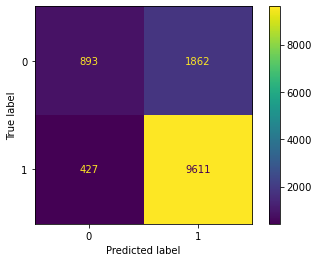

In [269]:
logreg_cm = confusion_matrix(y_test, logreg_preds)
ConfusionMatrixDisplay(logreg_cm).plot();

In [271]:
print(classification_report(y_test, logreg_preds))

              precision    recall  f1-score   support

           0       0.68      0.32      0.44      2755
           1       0.84      0.96      0.89     10038

    accuracy                           0.82     12793
   macro avg       0.76      0.64      0.67     12793
weighted avg       0.80      0.82      0.80     12793



Although our logistic regression model is scoring well overall with 82% accuracy, it's not performing well with the expired text data (0). The funded data (1) has low false negatives and predicts 96% correctly (recall score). However, it's only predicting 32% correctly for the expired loans which gives us a high false positive score. With this model we are predicting most loans to be funded and giving those whose text information for their loans are not good enough for funding false hope that they are likely to be funded when they are not for whatever reason. 

### Random Forest

In [245]:
rfc = RandomForestClassifier()
rfc.fit(X_train_tdvec, y_train)

In [227]:
# scoring with default random forest and default vectorizer
print(f'Train score: {rfc.score(X_train_tdvec, y_train)}')
print(f'Test score: {rfc.score(X_test_tdvec, y_test)}')

Train score: 0.999973942726112
Test score: 0.8070038302196514


In [243]:
# scoring with ngrams range of 1,2 in vectorizer
print(f'Train score: {rfc.score(X_train_tdvec, y_train)}')
print(f'Test score: {rfc.score(X_test_tdvec, y_test)}')

Train score: 0.7846626885895198
Test score: 0.7846478542953178


The Random Forest model is overfit for the default parameters. The increased ngrams in the vectorizer provide a better fit but the score hasn't improved over the null scores.

### AdaBoost

In [237]:
abc = AdaBoostClassifier(n_estimators=250)
abc.fit(X_train_tdvec, y_train)

AdaBoostClassifier(n_estimators=250)

In [233]:
# scoring w/default vectorizer and default adaboost
print(f'Train score: {abc.score(X_train_tdvec, y_train)}')
print(f'Test score: {abc.score(X_test_tdvec, y_test)}')

Train score: 0.8086874951142612
Test score: 0.8070819979676386


In [236]:
# scoring with increased estimators of 250 from 50
print(f'Train score: {abc.score(X_train_tdvec, y_train)}')
print(f'Test score: {abc.score(X_test_tdvec, y_test)}')

Train score: 0.8097297860697814
Test score: 0.8113812241069335


This score improved over the null model but not as well as the logistic regression.

### GradientBoost

In [262]:
gb = GradientBoostingClassifier()
gb.fit(X_train_tdvec, y_train)

GradientBoostingClassifier(min_samples_split=3)

In [263]:
# scoring 
print(f'Train score: {gb.score(X_train_tdvec, y_train)}')
print(f'Test score: {gb.score(X_test_tdvec, y_test)}')

Train score: 0.8228105375615603
Test score: 0.8174783084499335


This model is also an improvement over the null model but not as well as the logistic regression.

# Reproducing logreg score from above to extract features and complete interpretations.

In [19]:
# rereading in data
kiva_kenya = pd.read_csv('/Users/precious/dsi/Group-Project/kiva_kenya.csv')

In [20]:
kiva_kenya.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51170 entries, 0 to 51169
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LOAN_ID                 51170 non-null  int64 
 1   COUNTRY_NAME            51170 non-null  object
 2   STATUS                  51170 non-null  int64 
 3   DESCRIPTION_TRANSLATED  51170 non-null  object
 4   LOAN_USE                51170 non-null  object
 5   TAGS                    51170 non-null  object
 6   all_text                51170 non-null  object
 7   joined_text             51019 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.1+ MB


Noticed null rows not taken into consideration in above models. Will check original data to be sure they were always null and not as result of saving data to new csv.

In [6]:
kiva_kenya[kiva_kenya['joined_text'].isnull()]

,LOAN_ID,COUNTRY_NAME,STATUS,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,all_text,joined_text
1003,826815,Kenya,1,,,,[],NaN
1228,882956,Kenya,1,,,,[],NaN
1416,1119019,Kenya,1,,,,[],NaN
1773,921931,Kenya,1,,,,[],NaN
2156,937491,Kenya,1,,,,[],NaN
...,...,...,...,...,...,...,...,...
48433,993758,Kenya,1,,,,[],NaN
49010,877307,Kenya,1,,,,[],NaN
49294,920528,Kenya,1,,,,[],NaN
49521,880729,Kenya,1,,,,[],NaN


In [7]:
# checking empty rows for content
kiva_kenya['DESCRIPTION_TRANSLATED'][1003]

' '

In [8]:
# reading in original dataset to check content
old_kiva = pd.read_csv('/Users/precious/dsi/Group-Project/kivamix.csv')

In [10]:
# verifying empty rows were always empty
old_kiva[old_kiva['LOAN_ID']==877280]

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,...,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,year
408679,877280,NaN,NaN,NaN,NaN,275.0,275.0,1,NaN,NaN,...,7,4,3,NaN,NaN,NaN,NaN,monthly,field_partner,2015


In [21]:
# dropping empty rows
kiva_kenya.dropna(inplace=True)

In [22]:
kiva_kenya.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51019 entries, 0 to 51169
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LOAN_ID                 51019 non-null  int64 
 1   COUNTRY_NAME            51019 non-null  object
 2   STATUS                  51019 non-null  int64 
 3   DESCRIPTION_TRANSLATED  51019 non-null  object
 4   LOAN_USE                51019 non-null  object
 5   TAGS                    51019 non-null  object
 6   all_text                51019 non-null  object
 7   joined_text             51019 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.5+ MB


### Modeling Combined Text Data to Reproduce Logistic Regression Model from Above Section

In [24]:
# defining variables for models
X = kiva_kenya['joined_text']
y = kiva_kenya['STATUS']

In [25]:
# null model values
y.value_counts(normalize=True)

1    0.784041
0    0.215959
Name: STATUS, dtype: float64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [79]:
# checking number of features
X_train_tdvec.shape

(38264, 292840)

In [138]:
# vectorizing data added max_features to improve score and produced same results as earlier
tdvec = TfidfVectorizer(ngram_range=(1,2), max_features=20_000)
X_train_tdvec = tdvec.fit_transform(X_train)
X_test_tdvec = tdvec.transform(X_test)

In [139]:
# instantiating and fitting logestic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tdvec, y_train)

LogisticRegression(max_iter=1000)

In [140]:
# scoring logistic regression
print(f'Train score: {logreg.score(X_train_tdvec, y_train)}')
print(f'Test score: {logreg.score(X_test_tdvec, y_test)}')

Train score: 0.8421231444699979
Test score: 0.8210113680909448


In [141]:
# creating predictions from test data
logreg_preds = logreg.predict(X_test_tdvec)

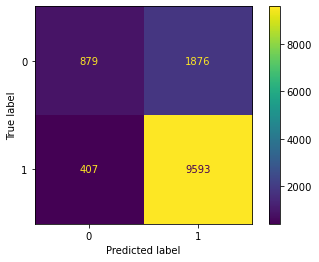

In [142]:
# showing predictions vs true status where 0=expired and 1=funded
logreg_cm = confusion_matrix(y_test, logreg_preds)
ConfusionMatrixDisplay(logreg_cm).plot();

In [143]:
print(f'ROC AUC: {roc_auc_score(y_test, logreg_preds)}')

ROC AUC: 0.6391781306715063


In [144]:
print(classification_report(y_test, logreg_preds))

              precision    recall  f1-score   support

           0       0.68      0.32      0.44      2755
           1       0.84      0.96      0.89     10000

    accuracy                           0.82     12755
   macro avg       0.76      0.64      0.66     12755
weighted avg       0.80      0.82      0.79     12755



I used NLP (natural language processing) to see if we could determine whether or not a Kiva loan would be funded based off the words used in the loan request. My independent variable was a combination of the loan description translated into English, the tags associated with the loan and a short description of what the loan will be used for. My dependent variable is whether a loan was funded or expired. For my model, I only focused on loans from Kenya. \
\
To preprocess the data, I removed punctuation from the text and plural forms of words to make the words more uniform. I also removed common english words that don't lend much to predictions. I turned my text into a structured numeric dataframe using Tf-IDF Vectorizer which scores words on their importance when used in one document relative to all other documents and gives more weight to words used often in one document but not used in others. I used an ngram range of (1,2) looking at not only single words but also words combined with one of their adjacent words. I also used a max of the top 20,000 features when creating the corpus. \
\
For modeling, I used a logistic regression model to predict the outcome of a loan and classify it as either funded or expired. On the training data we received a score of .84 and on testing data we have a score of .82. This shows that our model has a good fit on the data. It's also an improvement of 4pts above our null model which had a score of .78. This tells us there are word combinations in the data that aren't impacting the dependent variable, but the model is performing at a decent rate where 1.0 is perfect. \
\
We have an accuracy rate of .82 when predicting whether a loan will be funded or expired. Our model performs well when predicting funded models but not so much when predicting a loan will expire without being funded. For our funded predictions, we have a precision score of .84 which tells us out of all the loans we predicted to be funded 84% actually were. Our recall score is .96, which tells us that out of all the loans that were funded we predicted 96% of those correctly. Our f1-score of .89 is a weighted average of the precision and recall scores and tells us how well we did when predicting a loan will be funded. \
\
Unfortunately, the model does not perform as well for expired loans. Only 68% of our predictions for expired loans were correct, and out of all the loans that were expired, we only predicted 32% of those correctly. Our weighted average for expired loans, or f1-score is .44. \
\
Since we are more interested in finding words that improve the chances of a loan being funded, I created a dataframe showing how each word impacts the prediction. From the dataframe, we can see that smaller loans are more likely to be funded, specifically loan with kes 20,000 (with kes meaning Kenyan Shillings) and kes 30,000 in the description are more likely to be funded than any other amount, and requests for kes 60,000 or more negatively impact your chances of funding. Also, women borrowers are more likely to receive full funding than men. Specifically the following word combinations have a positive impact on funding: single parent, single mother/mom, widow, group farmer and the user_favorite tag. Some word combinations that negatively impact funding are mentioning man, married man or father. Mentioning motorcycle or shop also negatively impact the likelihood of funding. Something else to take note of is that parent by itself negatively impacts funding but single parent has one of the 6th highest positive impact score. 

In [145]:
# creating dataframe of coefs
word_coef_df = pd.DataFrame({'coefs': logreg.coef_[0], 'features': tdvec.get_feature_names()})
# word_coef_df.sort_values(by='coefs',ascending=False,inplace=True)

In [151]:
# top 20 features and their coefficients
word_coef_df.nlargest(20, 'coefs')

,coefs,features
95,5.657314,20 000
178,3.543666,30 000
10362,3.511416,kes 20
94,3.492091,20
18866,3.455082,user_favorite
17068,3.174807,single parent
17065,2.825557,single mother
19509,2.508753,widowed
177,2.384389,30
19505,2.325668,widow


In [149]:
# lowest 20 features and their coefficients
word_coef_df.nsmallest(20, 'coefs')

,coefs,features
42,-4.469611,100 000
41,-4.370316,100
11990,-4.066097,man
81,-2.806446,150 000
80,-2.754315,150
289,-2.738951,80 000
60,-2.732628,120 000
16941,-2.706685,shop
13195,-2.685128,nhe
10351,-2.659260,kes 100
